# EDA 

In [25]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# display multiple outputs, default is 'last_expr' (last expression)
# http://ipython.readthedocs.io/en/stable/config/options/terminal.html
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa
import psycopg2 as pg
import seaborn as sns

from psycopg2.extras import execute_values

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from scipy.stats import zscore

### Pull down all features

In [2]:
query = '''
    SELECT *
    FROM prod.features
    WHERE "Season Type" = 'NCAA Tourney' and
        holdout_s1 = 0 and
        holdout_s2 = 0
'''

conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

df = pd.read_sql_query(query, conn)

In [22]:
df.shape
df.dtypes.value_counts()
df.describe().T

(1426, 64)

float64    51
int64      11
object      2
dtype: int64

,count,mean,std,min,25%,50%,75%,max
Season,1426.0,2.008050e+03,3.176268,2003.000000,2005.000000,2008.000000,2011.000000,2013.000000
DayNum,1426.0,1.390996e+02,4.218910,134.000000,136.000000,137.000000,139.000000,154.000000
Team,1426.0,1.293577e+03,104.185887,1102.000000,1210.000000,1281.000000,1393.000000,1462.000000
Opponent,1426.0,1.293577e+03,104.185887,1102.000000,1210.000000,1281.000000,1393.000000,1462.000000
Outcome,1426.0,5.000000e-01,0.500175,0.000000,0.000000,0.500000,1.000000,1.000000
Score,1426.0,6.894741e+01,12.066513,29.000000,61.000000,69.000000,77.000000,121.000000
OpponentScore,1426.0,6.894741e+01,12.066513,29.000000,61.000000,69.000000,77.000000,121.000000
NumOT,1426.0,7.433380e-02,0.311331,0.000000,0.000000,0.000000,0.000000,2.000000
holdout_s1,1426.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
holdout_s2,1426.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Ordered correlation between target and features

In [16]:
target = ['Outcome']
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team',
            'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team',
            "FieldGoalPct_Team", "TwoPointAttPct_Team", "ThreePointAttPct_Team",
            "FieldGoalAtt_Team", "TwoPointAtt_Team", "ThreePointAtt_Team",
            "FreeThrowAtt_Team", "Assists_Team", "Turnovers_Team", "Steals_Team",
            "Blocks_Team", "PersonalFouls_Team", "cum_winpct_v_opp",
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'SeedDiff',
            'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor'
           ]

cm = df[target+features].corr()['Outcome'].sort_values()
cm

SeedDiff                 -0.505541
AvgRank                  -0.327037
OpponentWinPct           -0.263281
PersonalFouls_Team       -0.105491
Turnovers_Team           -0.097860
AvgPointsAgainst         -0.097735
ThreePointAttPct_Team    -0.057199
ThreePointAtt_Team       -0.005199
FreeThrowPct_Team         0.025110
FreeThrowAtt_Team         0.036212
ThreePointPct_Team        0.045726
TwoPointAttPct_Team       0.057199
Steals_Team               0.085883
cum_winpct_v_opp          0.111085
DefensiveRebounds_Team    0.113723
TwoPointPct_Team          0.125174
TwoPointAtt_Team          0.128340
OffensiveRebounds_Team    0.140307
FieldGoalPct_Team         0.144983
Assists_Team              0.146352
FieldGoalAtt_Team         0.148844
Blocks_Team               0.175963
AvgPointsFor              0.185305
WinPct                    0.263281
AvgNetPointsFor           0.318327
OpponentAvgRank           0.327037
WinPctDiff                0.369306
Outcome                   1.000000
Name: Outcome, dtype

## Ordered correlation between target and normalized features

In [31]:
target = ['Outcome']
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team',
            'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team',
            "FieldGoalPct_Team", "TwoPointAttPct_Team", "ThreePointAttPct_Team",
            "FieldGoalAtt_Team", "TwoPointAtt_Team", "ThreePointAtt_Team",
            "FreeThrowAtt_Team", "Assists_Team", "Turnovers_Team", "Steals_Team",
            "Blocks_Team", "PersonalFouls_Team", "cum_winpct_v_opp",
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'SeedDiff',
            'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor'
           ]

df_std = df[features].apply(lambda x: (x - df_std.mean()) / df_std.std(), axis=1)
df_std['Outcome'] = pd.Series(df['Outcome'])
df_std.head()

,AvgRank,OpponentAvgRank,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,FieldGoalPct_Team,TwoPointAttPct_Team,ThreePointAttPct_Team,...,PersonalFouls_Team,cum_winpct_v_opp,WinPct,OpponentWinPct,WinPctDiff,SeedDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor,Outcome
0,4.431467,4.454937,-0.108775,-1.475096,-2.428360,0.731726,0.059775,-0.753401,-0.212540,0.212540,...,0.359551,NaN,-1.595616,-3.148646,1.089224,0.000000,-0.220530,1.408268,-1.682749,0
1,4.454937,4.431467,-1.601532,0.104208,1.621724,0.142598,-0.829247,-1.407931,0.139115,-0.139115,...,0.815431,NaN,-3.148646,-1.595616,-1.089224,0.000000,-0.530390,3.148129,-3.806043,1
2,-0.372933,0.409031,-0.184614,0.037326,0.196375,0.778404,-0.672519,-0.502697,-0.987939,0.987939,...,0.109257,NaN,0.733929,-0.472974,0.846466,-1.198418,-0.221872,0.374862,-0.641379,0
3,-0.615149,0.981692,-0.182486,0.109277,-0.307972,1.088173,-0.810331,-0.133146,-0.218337,0.218337,...,2.026259,NaN,0.451562,-1.936809,1.675093,-1.464733,1.562402,1.309269,0.530932,1
4,0.099930,0.085440,0.208526,0.469255,0.479399,-0.000971,0.505547,0.347758,-0.391414,0.391414,...,0.501588,NaN,-0.142785,-1.522501,0.967676,0.133158,0.608919,0.805155,-0.090679,1


In [33]:
df_std.corr()['Outcome'].sort_values()

SeedDiff                 -0.505541
AvgRank                  -0.327037
OpponentWinPct           -0.263281
PersonalFouls_Team       -0.105491
Turnovers_Team           -0.097860
AvgPointsAgainst         -0.097735
ThreePointAttPct_Team    -0.057199
ThreePointAtt_Team       -0.005199
FreeThrowPct_Team         0.025110
FreeThrowAtt_Team         0.036212
ThreePointPct_Team        0.045726
TwoPointAttPct_Team       0.057199
Steals_Team               0.085883
cum_winpct_v_opp          0.111085
DefensiveRebounds_Team    0.113723
TwoPointPct_Team          0.125174
TwoPointAtt_Team          0.128340
OffensiveRebounds_Team    0.140307
FieldGoalPct_Team         0.144983
Assists_Team              0.146352
FieldGoalAtt_Team         0.148844
Blocks_Team               0.175963
AvgPointsFor              0.185305
WinPct                    0.263281
AvgNetPointsFor           0.318327
OpponentAvgRank           0.327037
WinPctDiff                0.369306
Outcome                   1.000000
Name: Outcome, dtype

## Ordered correlation between target and logged features

In [35]:
target = ['Outcome']
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team',
            'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team',
            "FieldGoalPct_Team", "TwoPointAttPct_Team", "ThreePointAttPct_Team",
            "FieldGoalAtt_Team", "TwoPointAtt_Team", "ThreePointAtt_Team",
            "FreeThrowAtt_Team", "Assists_Team", "Turnovers_Team", "Steals_Team",
            "Blocks_Team", "PersonalFouls_Team", "cum_winpct_v_opp",
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'SeedDiff',
            'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor'
           ]

df_ln = df[features].apply(np.log)
df_ln['Outcome'] = pd.Series(df['Outcome'])
df_ln.head()

,AvgRank,OpponentAvgRank,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,FieldGoalPct_Team,TwoPointAttPct_Team,ThreePointAttPct_Team,...,PersonalFouls_Team,cum_winpct_v_opp,WinPct,OpponentWinPct,WinPctDiff,SeedDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor,Outcome
0,5.477639,5.482071,-0.675330,-1.133554,-0.489276,2.585948,3.203587,-0.805635,-0.411954,-1.085760,...,2.903694,NaN,-0.510826,-0.802346,-1.885692,-inf,4.287716,4.260329,0.676342,0
1,5.482071,5.477639,-0.758353,-1.009033,-0.271286,2.505526,3.135494,-0.838832,-0.383694,-1.143631,...,2.948190,NaN,-0.802346,-0.510826,NaN,-inf,4.265590,4.362440,NaN,1
2,3.076229,4.044696,-0.679386,-1.014004,-0.342708,2.592051,3.147840,-0.793206,-0.477241,-0.968882,...,2.878395,NaN,-0.189242,-0.342945,-2.137842,NaN,4.287621,4.194345,1.869146,0
3,2.370795,4.419216,-0.679272,-1.008658,-0.369254,2.631641,3.136992,-0.775162,-0.412426,-1.084834,...,3.057575,NaN,-0.223144,-0.567983,-1.455289,NaN,4.406313,4.254193,2.448130,1
4,3.763379,3.748032,-0.658537,-0.982331,-0.328115,2.484907,3.236061,-0.752159,-0.426641,-1.057561,...,2.917771,NaN,-0.298494,-0.498991,-2.004015,0.000000,4.344643,4.222351,2.182784,1


In [36]:
df_ln.corr()['Outcome'].sort_values()

AvgRank                  -0.396717
SeedDiff                 -0.306093
OpponentWinPct           -0.256311
PersonalFouls_Team       -0.107371
AvgPointsAgainst         -0.095287
Turnovers_Team           -0.094251
ThreePointAttPct_Team    -0.059303
ThreePointAtt_Team       -0.004552
FreeThrowPct_Team         0.025416
FreeThrowAtt_Team         0.036644
ThreePointPct_Team        0.047571
TwoPointAttPct_Team       0.055664
Steals_Team               0.086599
cum_winpct_v_opp          0.089379
DefensiveRebounds_Team    0.112145
TwoPointAtt_Team          0.123910
TwoPointPct_Team          0.126798
OffensiveRebounds_Team    0.140272
FieldGoalPct_Team         0.145545
Assists_Team              0.146946
FieldGoalAtt_Team         0.148036
Blocks_Team               0.172914
AvgPointsFor              0.185595
WinPctDiff                0.208219
WinPct                    0.256311
AvgNetPointsFor           0.290916
OpponentAvgRank           0.396717
Outcome                   1.000000
Name: Outcome, dtype

### Correlation Viz

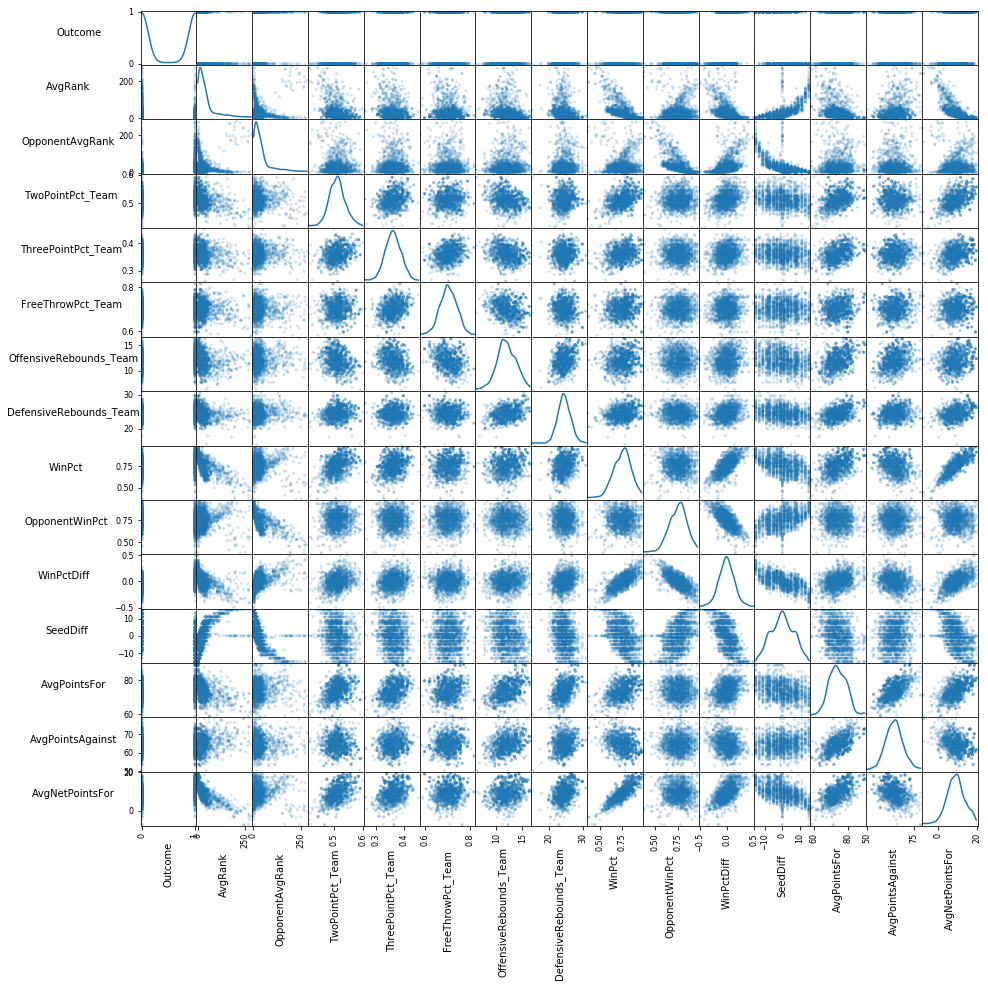

In [11]:
target = ['Outcome']
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team',
            'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team',
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'SeedDiff',
            'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor'
           ]

axs = pd.plotting.scatter_matrix(df[target+features], alpha=0.2, figsize=(15, 15), diagonal='kde')
n = len(df[target+features].columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

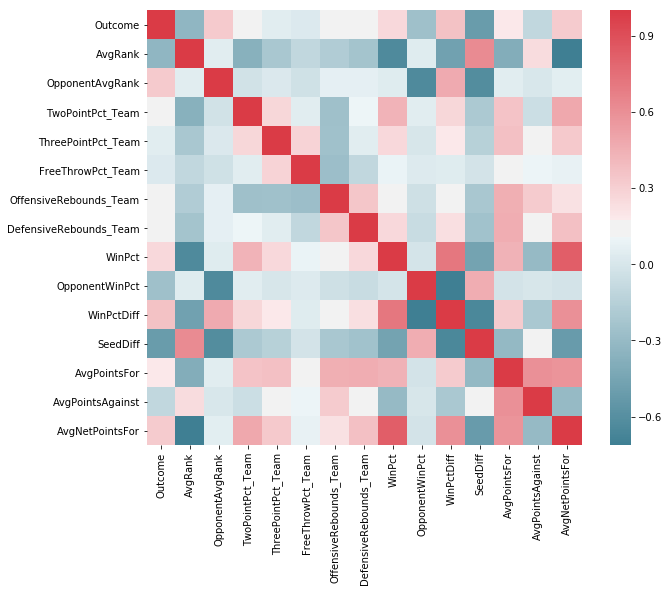

In [32]:
target = ['Outcome']
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team',
            'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team',
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'SeedDiff',
            'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor'
           ]

cm = df[target+features].corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, mask=np.zeros_like(cm, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)